## Conv Net을 사용한 시퀀스 처리
컴퓨터 비전에서 뛰어난 성능을 보이는 컨브넷(Conv Net)의 특징이 시퀀스 처리와도 관련되어 있음  
-> 시간을 2D 이미지의 높이와 너비 같은 공간의 차원으로 다룰 수 있음

### 1D Conv
특정 시퀀스 처리 문제에서 RNN과 견줄 만한 성능을 보임  
-> 1D Conv는 전형적으로 **팽창된 커널(dilated kernel)** 과 함께 사용 됨  
-> 최근 오디오 생성과 기계 번역 분야에서 큰 성공  
-> 텍스트 분류나 시계열 예측 같은 간단한 문제에서 작은 1D 컨브넷이 RNN을 대신해 빠르게 처리 가능


1D 합성곱은 시퀀스에 있는 지역 패턴을 인식할 수 있음  
-> 동일한 변환이 시퀀스에 있는 모든 패치에 적용되기 때문에 특정 위치에서 학습한 패턴을 나중에 다른 위치에서 인식 가능 (이동 불변성(translation invariant))  

#### 서브 샘플링(SubSampling)
1D 풀링 연산은 2D 풀링 연산과 동일  
-> 입력의 길이를 줄이기 위해 사용

In [2]:
import tensorflow as tf
from keras.datasets import imdb
from keras.utils import pad_sequences

max_features = 10000
max_len = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(f"x_train: {len(x_train)}\nx_test: {len(x_test)}")

print("시퀀스 패딩 (samples x time)")
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)
print(f"x_train: {len(x_train)}\nx_test: {len(x_test)}")

x_train: 25000
x_test: 25000
시퀀스 패딩 (samples x time)
x_train: 25000
x_test: 25000


1D 컨브넷은 2D 컨브넷과 비슷한 방식으로 구성  
-> Conv + Pooling or Flatten + Dense

2D 컨브넷에서 3*3 합성곱 윈도우는 9개의 특성을 고려함  
-> 1D 컨브넷에선 크기가 3인 합성곱 윈도우는 3개의 특성만 고려  
-> 큰 합성곱 윈도우를 사용할 수 있음 (7 or 9)

In [3]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation="relu"))
model.add(layers.MaxPool1D(5))
model.add(layers.Conv1D(32, 7, activation="relu"))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 494, 32)           28704     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 32)            7200      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 3

In [4]:
model.compile(
    optimizer=RMSprop(),
    loss="binary_crossentropy",
    metrics=["acc"]
)

with tf.device(":/GPU:0"):
    hist = model.fit(x_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 21s 33ms/step - loss: 0.5354 - acc: 0.7829 - val_loss: 0.4572 - val_acc: 0.8754
Epoch 2/10
625/625 [==============================] - 16s 26ms/step - loss: 0.4106 - acc: 0.8919 - val_loss: 0.4135 - val_acc: 0.8762
Epoch 3/10
625/625 [==============================] - 21s 33ms/step - loss: 0.3158 - acc: 0.9291 - val_loss: 0.6973 - val_acc: 0.8586
Epoch 4/10
625/625 [==============================] - 20s 32ms/step - loss: 0.2463 - acc: 0.9602 - val_loss: 0.6839 - val_acc: 0.8826
Epoch 5/10
625/625 [==============================] - 19s 31ms/step - loss: 0.1908 - acc: 0.9780 - val_loss: 0.9289 - val_acc: 0.8804
Epoch 6/10
625/625 [==============================] - 19s 31ms/step - loss: 0.1657 - acc: 0.9837 - val_loss: 0.9730 - val_acc: 0.8788
Epoch 7/10
625/625 [==============================] - 20s 32ms/step - loss: 0.1527 - acc: 0.9858 - val_loss: 1.1627 - val_acc: 0.8786
Epoch 8/10
625/625 [==============================] - 17s 28ms

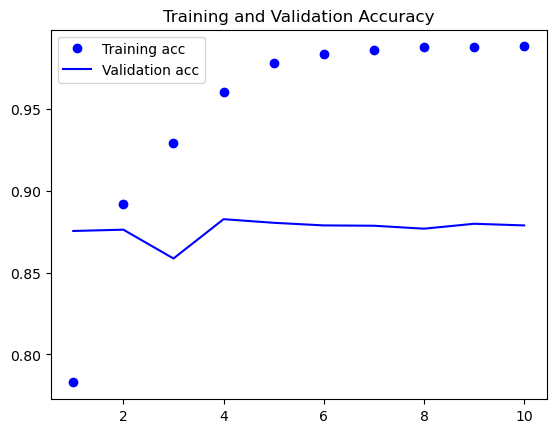

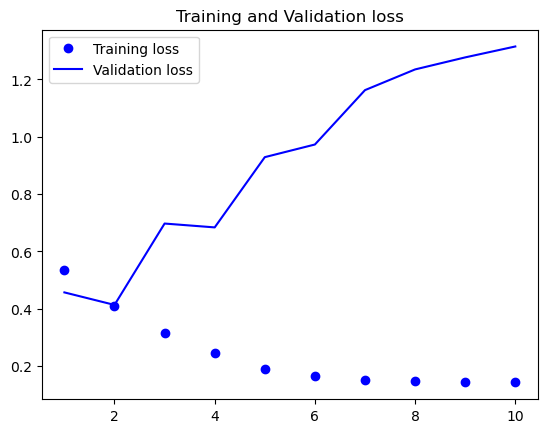

In [6]:
import matplotlib.pyplot as plt

acc = hist.history["acc"]
val_acc = hist.history["val_acc"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()

plt.show()

### CNN과 RNN을 연결해 긴 시퀀스 처리하기
1D Conv넷은 입력 패치를 독립적으로 처리하기 때문에 RNN과 달리 타임스텝의 순서에 민감하지 않음  
-> 장기간 패턴을 인식하기 위해 많은 합성곱 층과 풀링 층을 쌓을 수 있음


In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation="relu", input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation="relu"))
model.add(layers.MaxPooling1D())
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(
    optimizer=RMSprop(),
    loss="mae"
)

with tf.device(":/GPU:0"):
    hist = model.fit(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 16s 30ms/step - loss: 0.4455 - val_loss: 0.4632
Epoch 2/20
500/500 [==============================] - 17s 33ms/step - loss: 0.4037 - val_loss: 0.4461
Epoch 3/20
500/500 [==============================] - 15s 30ms/step - loss: 0.3852 - val_loss: 0.4513
Epoch 4/20
500/500 [==============================] - 15s 30ms/step - loss: 0.3729 - val_loss: 0.4543
Epoch 5/20
500/500 [==============================] - 16s 33ms/step - loss: 0.3637 - val_loss: 0.4799
Epoch 6/20
500/500 [==============================] - 17s 35ms/step - loss: 0.3544 - val_loss: 0.4622
Epoch 7/20
500/500 [==============================] - 15s 30ms/step - loss: 0.3454 - val_loss: 0.4701
Epoch 8/20
500/500 [==============================] - 15s 30ms/step - loss: 0.3417 - val_loss: 0.4649
Epoch 9/20
500/500 [==============================] - 15s 31ms/step - loss: 0.3370 - val_loss: 0.4945
Epoch 10/20
500/500 [==============================] - 16s 32ms/step - loss: 0.333

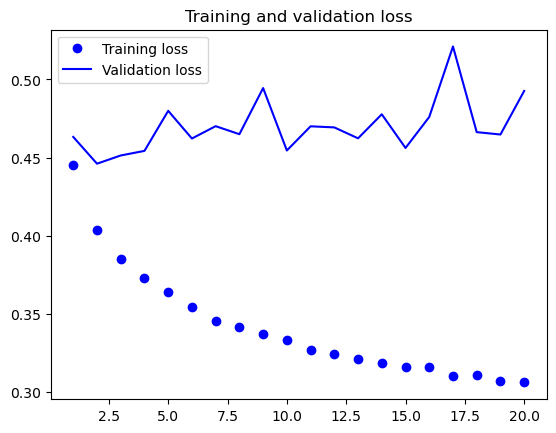

In [3]:
import matplotlib.pyplot as plt

loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

`validation loss`가 0.40대에 머물러있는 모습을 볼 수 있음  
-> 작은 합성곱 네트워크를 사용한 경우 상식 수준의 기준점(0.29)를 넘지 못했음  
-> 1D Conv Net이 입력 시계열에 있는 패턴을 보고 이 패터의 시간 축의 위치를 고려하지 않았기 때문  

컨브넷의 속도와 경량함을 RNN의 순서 감지 능력과 결합하는 한 가지 전략은 1D Conv Net을 RNN 이전에 전처리 단계로 사용하는 것  
-> 너무 긴 시퀀스를 다룰 때 도움이 됨  
-> Conv Net이 긴 입력 시퀀스를 더 짧은 고수준 특성의 시퀀스로 변환 (다운 샘플링)

In [4]:
step = 3
lookback = 1440
delay = 144

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step)

val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 -lookback) // 128

In [5]:
# 1D Conv - 1D Conv - GRU
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation="relu", input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation="relu"))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(
    optimizer=RMSprop(),
    loss="mae"
)

with tf.device(":/GPU:0"):
    hist = model.fit(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 144s 284ms/step - loss: 0.3312 - val_loss: 0.2866
Epoch 2/20
500/500 [==============================] - 140s 281ms/step - loss: 0.2988 - val_loss: 0.2811
Epoch 3/20
500/500 [==============================] - 141s 281ms/step - loss: 0.2791 - val_loss: 0.2853
Epoch 4/20
500/500 [==============================] - 144s 288ms/step - loss: 0.2705 - val_loss: 0.2750
Epoch 5/20
500/500 [==============================] - 143s 286ms/step - loss: 0.2627 - val_loss: 0.2733
Epoch 6/20
500/500 [==============================] - 142s 284ms/step - loss: 0.2560 - val_loss: 0.2828
Epoch 7/20
500/500 [==============================] - 136s 273ms/step - loss: 0.2491 - val_loss: 0.2893
Epoch 8/20
500/500 [==============================] - 138s 277ms/step - loss: 0.2432 - val_loss: 0.2919
Epoch 9/20
500/500 [==============================] - 140s 281ms/step - loss: 0.2377 - val_loss: 0.2868
Epoch 10/20
500/500 [==============================] - 135s 269m

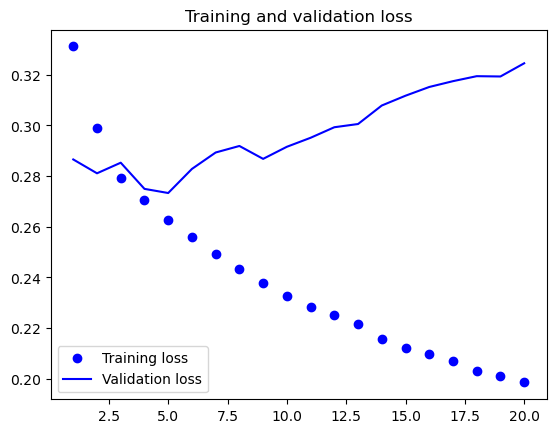

In [6]:
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

규제가 있는 GRU 모델만큼 성능이 좋지는 않지만, 훨씬 빠르기 때문에 데이터를 2배 더 많이 처리할 수 있음

### 정리
1. 2D Conv가 2D 공간의 시각적 패턴을 잘 처리하는 것처럼, 1D Conv은 시간에 따른 패턴을 잘 처리함 (일부 문제에서 RNN을 대체 가능)
2. 전형적으로 2D Conv와 동일한 구조로 층을 구성 (Conv - Pooling - Dense or Flatten)
3. 시퀀스의 길이를 줄이고 RNN이 처리할 유용한 표현을 추출할 목적으로 사용하기 좋음